<a href="https://colab.research.google.com/github/yasirabd/research-diagnostic-turbine/blob/main/Prognostics_Turbine_Bearing_1_Cooling_Loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Create: 7 Desember 2021*<br>
*Last Update: 17 January 2022*<br>
*Author: Yasir Abdur Rohman*<br>
**Property of PT Indonesia Power & Lab Getaran & Diagnosis Mesin Undip**

---

# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

In [2]:
from scipy.spatial import distance

from sklearn.metrics import mean_squared_error

# Load Data

In [25]:
path = "/content/drive/MyDrive/Prescriptive Maintenance/Data/Turbine Generator - SLA5/export_datasla5_01jan20-31mar20.csv"
data = pd.read_csv(path)
data.head()

,date,Generator Gross Capacity,Turbine Bearing #01 Metal Temperature,Turbine Bearing #07 X Vibration,Turbine Bearing #07 Y Vibration,Turbine Bearing #08 X Vibration,Turbine Bearing #08 Y Vibration,Turbine Bearing #09 X Vibration,Turbine Bearing #09 Y Vibration,Turbine Bearing #10 X Vibration,Turbine Bearing #10 Y Vibration,Turbine First Stage Exit Metal Temperature,Turbine Gland Steam Pressure,Turbine Gland Steam Temperature,Turbine HP Bypass Spray Valve Position,Turbine HP Bypass Valve Position,Turbine HP Casing Expansion,Turbine HP Exhaust Casing Upper Metal Temperature,Turbine HP Exhaust Steam Temperature,Turbine HP Oil Pressure,Turbine LP A Exhaust Steam Temperature,Turbine LP B Exhaust Steam Temperature,Turbine Lube Oil Cooler Inlet Temperature,Turbine Lube Oil Cooler Outlet Temperature,Turbine Lube Oil Temperature,Turbine Main Steam Casing Lower Metal Temperature,Turbine Main Steam Casing Upper Metal Temperature,Turbine Outer Casing Lower Metal Temperature,Turbine Outer Casing Upper Metal Temperature,Turbine Reheat Steam Casing Lower Metal Temperature,Turbine Reheat Steam Casing Upper Metal Temperature,Turbine.Bearing 1 Drain Oil Temperature,Turbine.Bearing 1 Metal Temperature,Turbine.Bearing 1X Vibration,Turbine.Bearing 1Y Vibration,Turbine.Bearing 2 Drain Oil Temperature,Turbine.Bearing 2 Metal Temperature,Turbine.Bearing 2X Vibration,Turbine.Bearing 2Y Vibration,Turbine.Bearing 3 Drain Oil Temperature,...,Turbine.Bearing 4X Vibration,Turbine.Bearing 4Y Vibration,Turbine.Bearing 5 Drain Oil Temperature,Turbine.Bearing 5 Metal Temperature,Turbine.Bearing 5X Vibration,Turbine.Bearing 5Y Vibration,Turbine.Bearing 6 Drain Oil Temperature,Turbine.Bearing 6 Metal Temperature,Turbine.Bearing 6X Vibration,Turbine.Bearing 6Y Vibration,Turbine.Bearing Oil Pressure,Turbine.Differential Expansion,Turbine.Eccentricity,Turbine.Final Feedwater Flow,Turbine.Final Feedwater Pressure,Turbine.Final Feedwater Temperature,Turbine.RH Spray Flow,Turbine.SH Spray Flow A,Turbine.SH Spray Flow B,Turbine.Shaft Position,Turbine.Speed,Generator Bearing #07 Metal Temperature,Generator Bearing #08 Metal Temperature,Generator Bearing #09 Metal Temperature,Generator Bearing #10 Metal Temperature,Generator.Drain Oil Temperature Bearing #07,Generator.Drain Oil Temperature Bearing #08,Generator.Drain Oil Temperature Bearing #09,Generator.Drain Oil Temperature Bearing #10,Generator.Excitation Field Current,Generator.Excitation Field Voltage,Generator.Field Current,HP Turbine.Inlet Steam Flow,HP Turbine.Inlet Steam Pressure,HP Turbine.Inlet Steam Temperature A,HP Turbine.Inlet Steam Temperature B,HP Turbine.Outlet Steam Pressure A,HP Turbine.Outlet Steam Pressure B,HP Turbine.Outlet Steam Temperature A,HP Turbine.Outlet Steam Temperature B
0,2020-03-31 23:58:00,366.021057,84.66040,0.020706,0.013,0.028,0.028,0.033,0.027548,0.008941,0.012,427.001617,0.300576,150.136871,NaN,0.024969,22.369425,333.401276,337.169952,22.07634,36.851257,37.183376,56.550392,43.672570,43.672570,357.411000,361.001373,333.513900,335.726776,409.353900,407.872131,53.473434,78.457500,0.051571,0.074711,57.526466,86.91230,0.019237,0.042237,63.557230,...,0.043060,0.038651,62.558464,79.495445,0.032963,0.027939,61.093094,80.30031,0.011905,0.018895,1.507125,11.732198,0.0,1072.78500,144.060669,184.920959,2.084045,96.226920,55.955162,-0.211472,2999.89746,67.75384,61.449364,71.508156,72.65751,58.733060,58.781870,53.546757,54.254745,27.322529,19.272995,2097.65625,1104.45117,134.930634,541.563000,549.260900,27.388222,27.409430,335.860016,324.155300
1,2020-03-31 23:57:00,368.321625,84.64486,0.020429,0.013,0.028,0.028,0.033,0.027929,0.008957,0.012,426.988922,0.300171,150.104218,NaN,0.024969,22.380516,333.401276,337.084700,22.07634,36.861633,37.146103,56.548470,43.689873,43.689873,357.345800,361.001373,333.438354,335.623840,409.254456,407.781219,53.473434,78.407520,0.051742,0.074581,57.526466,87.00908,0.019096,0.042290,63.553402,...,0.042497,0.038026,62.558464,79.413970,0.032558,0.027309,61.093094,80

In [26]:
list(data)

['date',
 'Generator Gross Capacity',
 'Turbine Bearing #01 Metal Temperature',
 'Turbine Bearing #07 X Vibration',
 'Turbine Bearing #07 Y Vibration',
 'Turbine Bearing #08 X Vibration',
 'Turbine Bearing #08 Y Vibration',
 'Turbine Bearing #09 X Vibration',
 'Turbine Bearing #09 Y Vibration',
 'Turbine Bearing #10 X Vibration',
 'Turbine Bearing #10 Y Vibration',
 'Turbine First Stage Exit Metal Temperature',
 'Turbine Gland Steam Pressure',
 'Turbine Gland Steam Temperature',
 'Turbine HP Bypass Spray Valve Position',
 'Turbine HP Bypass Valve Position',
 'Turbine HP Casing Expansion',
 'Turbine HP Exhaust Casing Upper Metal Temperature',
 'Turbine HP Exhaust Steam Temperature',
 'Turbine HP Oil Pressure',
 'Turbine LP A Exhaust Steam Temperature',
 'Turbine LP B Exhaust Steam Temperature',
 'Turbine Lube Oil Cooler Inlet Temperature',
 'Turbine Lube Oil Cooler Outlet Temperature',
 'Turbine Lube Oil Temperature',
 'Turbine Main Steam Casing Lower Metal Temperature',
 'Turbine Main 

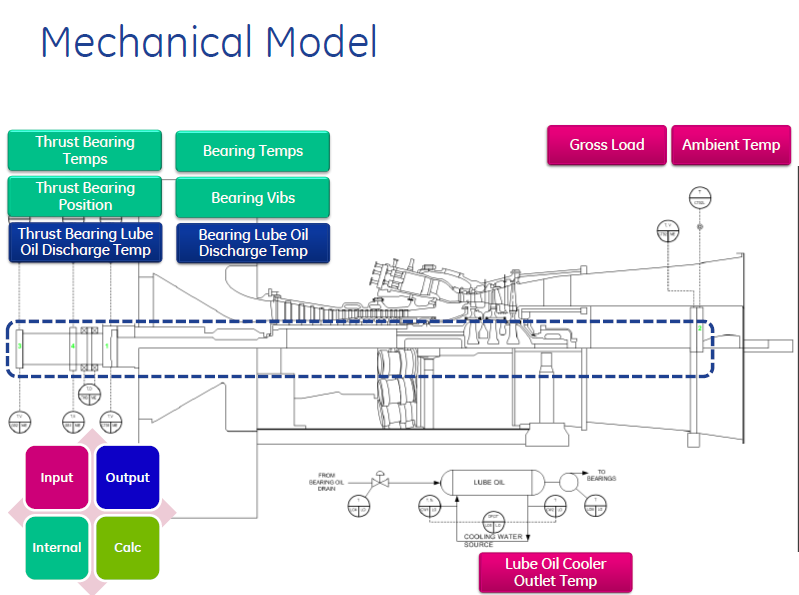

Bearing #1 sbb: 
- Gen gross capacity, 
- Turbine Lube oil cooler Outlet Temp, 
- Metal Temp (cuma ada 1; standar blueprint APM 4 per bearing) 
- Bearing oil press
- Turbine Drain oil Temp

## Problem Description

**Case:** ST Journal Bearing 1 - Cooling Loss

**Description:**

This fault indicates an abnormal change in the cooling of the supply oil to the bearings.  

Primary indicators are: 
- Journal Bearing Oil Outlet Temperature (Oil Return) is high; 
- and Bearing Metal Temperature is high.   

and 
- Priority 4 (lowest) is triggered when either Lube Oil Outlet Temperature is high or 
- Bearing Metal Temperature is high.  

The priority escalates depending on the severity of the change, and the number of sensors.  This fault triggers  Priority 2, 3 & 4.

**Input Tags:**
- LUBE_OIL_COOLER_OIL_OUTLET_TEMP
- GROSS_LOAD
- LUBE_OIL_COOLER_OIL_OUTLET_PRESS
- BRG_1_MTL_TEMP_1 
- AMBIENT_TEMP
- BRG_1_MTL_TEMP_2 
- BRG_1_MTL_TEMP_4 
- BRG_1_MTL_TEMP_3
- BRG_1_OIL_DRAIN_TEMP

**Expressions:**

```
if
    (ModelIndications(MECHANICAL,[SVH,SH,VH],[BRG_1_OIL_DRAIN_TEMP])>=1.0
    and
    ModelIndications(MECHANICAL,[SVH,SH,VH],[BRG_1_MTL_TEMP_1, BRG_1_MTL_TEMP_2, BRG_1_MTL_TEMP_3, BRG_1_MTL_TEMP_4])>=1.0)
then 
    Priority(2)
else if
    (ModelIndications(MECHANICAL,[SVH,SH,VH],[BRG_1_OIL_DRAIN_TEMP])>=1.0
    or 
        (ModelIndications(MECHANICAL,[VAR,H],[BRG_1_OIL_DRAIN_TEMP])>=1.0
        and
        ModelIndications(MECHANICAL,[VAR,H],[BRG_1_MTL_TEMP_1, BRG_1_MTL_TEMP_2, BRG_1_MTL_TEMP_3, BRG_1_MTL_TEMP_4])>=1.0))
then 
    Priority(3)
else if
    (ModelIndications(MECHANICAL,[VAR,H],[BRG_1_OIL_DRAIN_TEMP])>=1.0)
then 
    Priority(4)
else
    IsAssociated(MECHANICAL,[GROSS_LOAD,AMBIENT_TEMP,LUBE_OIL_COOLER_OIL_OUTLET_TEMP, LUBE_OIL_COOLER_OIL_OUTLET_PRESS])
```

# EDA

In [27]:
# select tag
cols = ['Generator Gross Capacity',
        'Turbine Lube Oil Cooler Outlet Temperature',
        # 'Turbine Bearing #01 Metal Temperature',
        'Turbine.Bearing 1 Metal Temperature',
        'Turbine.Bearing Oil Pressure',
        'Turbine.Bearing 1 Drain Oil Temperature']

data = data[['date']+cols]

# sort by index
data = data.sort_values(by='date').reset_index(drop=True)
data.head()

,date,Generator Gross Capacity,Turbine Lube Oil Cooler Outlet Temperature,Turbine.Bearing 1 Metal Temperature,Turbine.Bearing Oil Pressure,Turbine.Bearing 1 Drain Oil Temperature
0,2020-01-01 00:00:00,370.734800,43.280968,78.119934,1.525184,53.224167
1,2020-01-01 00:01:00,372.455200,43.316230,78.161460,1.525853,53.224167
2,2020-01-01 00:02:00,373.611400,43.246944,78.178790,1.528792,53.224167
3,2020-01-01 00:03:00,373.408722,43.223320,78.073660,1.527246,53.224167
4,2020-01-01 00:04:00,372.182159,43.314130,78.169060,1.526494,53.224167


**Note (Update 17 January 2022):**
- Remove `Turbine Bearing #01 Metal Temperature` because it has missing value 56%

## Data Information

In [28]:
# check data shape
data.shape

(131039, 6)

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131039 entries, 0 to 131038
Data columns (total 6 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   date                                        131039 non-null  object 
 1   Generator Gross Capacity                    121373 non-null  float64
 2   Turbine Lube Oil Cooler Outlet Temperature  121373 non-null  float64
 3   Turbine.Bearing 1 Metal Temperature         121372 non-null  float64
 4   Turbine.Bearing Oil Pressure                121373 non-null  float64
 5   Turbine.Bearing 1 Drain Oil Temperature     121369 non-null  float64
dtypes: float64(5), object(1)
memory usage: 6.0+ MB


In [30]:
# convert date to datetime
data['date'] = pd.to_datetime(data['date'])

In [31]:
# data date
print(f"Minimum date: {data['date'].min()}")
print(f"Maximum date: {data['date'].max()}")
print(f"Interval: {data['date'][1] - data['date'][0]}")

Minimum date: 2020-01-01 00:00:00
Maximum date: 2020-03-31 23:58:00
Interval: 0 days 00:01:00


## Missing Value

In [32]:
# check missing value
data.isnull().sum()

date                                             0
Generator Gross Capacity                      9666
Turbine Lube Oil Cooler Outlet Temperature    9666
Turbine.Bearing 1 Metal Temperature           9667
Turbine.Bearing Oil Pressure                  9666
Turbine.Bearing 1 Drain Oil Temperature       9670
dtype: int64

In [33]:
# check percentage missing value
data.isnull().sum()/len(data)*100

date                                          0.000000
Generator Gross Capacity                      7.376430
Turbine Lube Oil Cooler Outlet Temperature    7.376430
Turbine.Bearing 1 Metal Temperature           7.377193
Turbine.Bearing Oil Pressure                  7.376430
Turbine.Bearing 1 Drain Oil Temperature       7.379482
dtype: float64

**Note (Update 17 January 2022):**
- Ignore missing value
- for machine learning purpose, since it cant handle NaN values, we need to interpolate the data

In [36]:
# imputate data with interpolation
for col in cols:
    data[col] = data[col].interpolate(method='linear')

In [37]:
data.isnull().sum()

date                                          0
Generator Gross Capacity                      0
Turbine Lube Oil Cooler Outlet Temperature    0
Turbine.Bearing 1 Metal Temperature           0
Turbine.Bearing Oil Pressure                  0
Turbine.Bearing 1 Drain Oil Temperature       0
dtype: int64

## Descriptive Statistics

In [38]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Generator Gross Capacity,131039.0,517.561130,134.629671,0.190452,481.223084,586.217500,593.641126,611.258600
Turbine Lube Oil Cooler Outlet Temperature,131039.0,43.304580,2.560165,31.354956,43.279303,43.856150,44.400625,46.112560
Turbine.Bearing 1 Metal Temperature,131039.0,80.047658,10.718354,6.824649,79.500305,83.054150,84.136860,87.180405
Turbine.Bearing Oil Pressure,131039.0,1.518804,0.020981,0.830781,1.507416,1.514661,1.521822,1.776071
Turbine.Bearing 1 Drain Oil Temperature,131039.0,52.717190,4.557618,30.211567,53.159949,53.750595,54.230509,58.005474


Mean: 517.5611299942439, Median: 586.2175


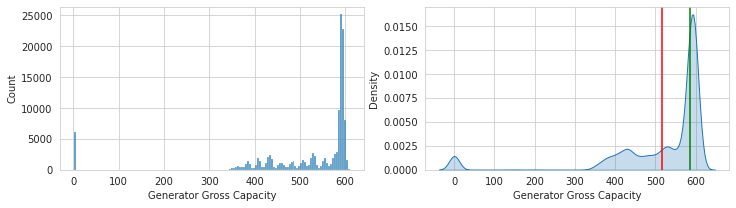

Mean: 43.3045802465816, Median: 43.85615


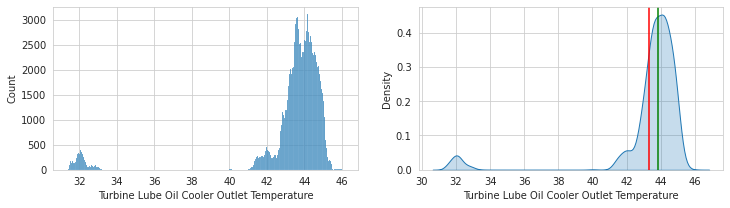

Mean: 80.04765834733973, Median: 83.05415


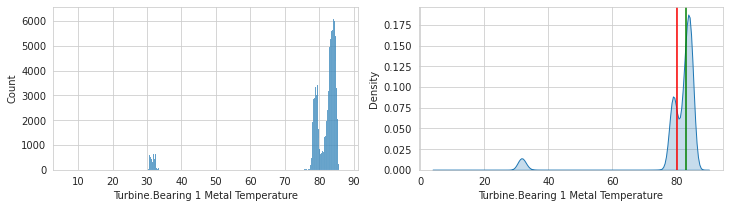

Mean: 1.5188036231917403, Median: 1.51466072


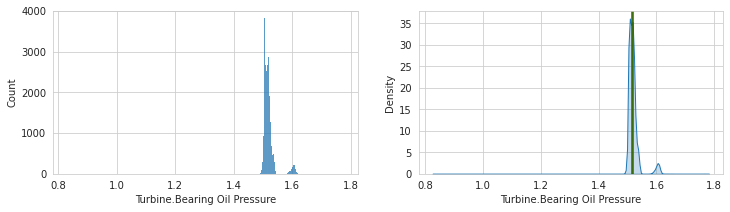

Mean: 52.717189670109434, Median: 53.7505951


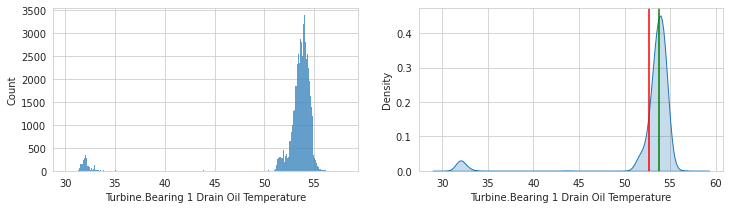

In [39]:
# distribution
for i,col in enumerate(cols):
    fig, axes = plt.subplots(1,2,figsize=(12,3))

    # histogram plot
    sns.histplot(data=data, x=col, ax=axes[0])

    # get mean and median
    mean = data[col].mean()
    median = data[col].median()
    print(f"Mean: {mean}, Median: {median}")

    sns.kdeplot(data=data, x=col, ax=axes[1], fill=True)
    axes[1].axvline(x=mean, color='red')
    axes[1].axvline(x=median, color='green')
    plt.show();

## Plotting

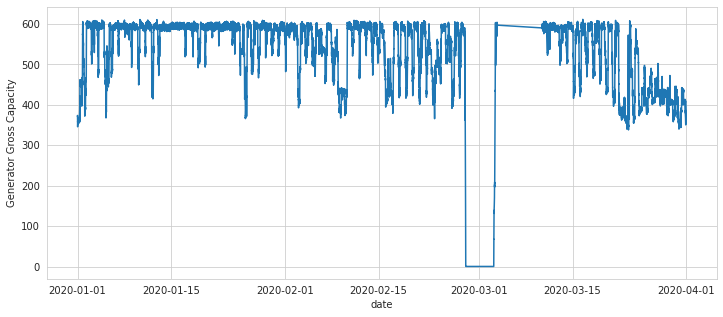

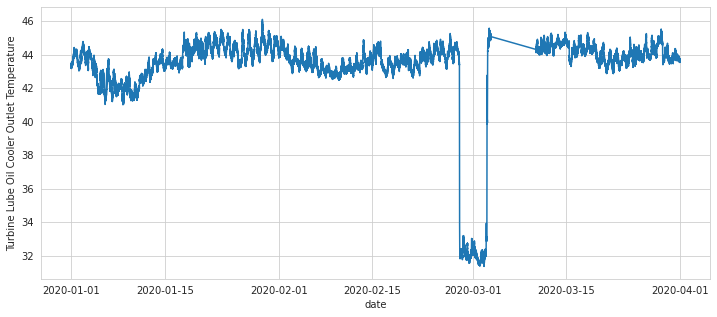

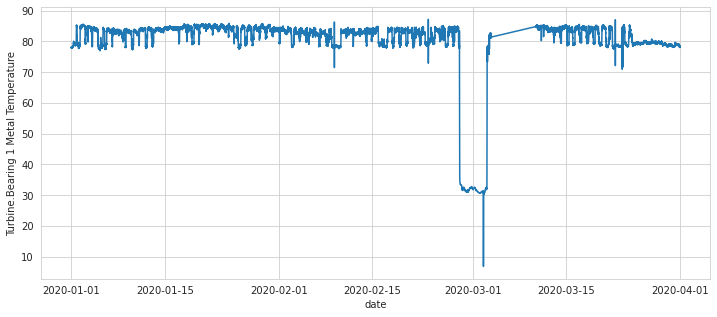

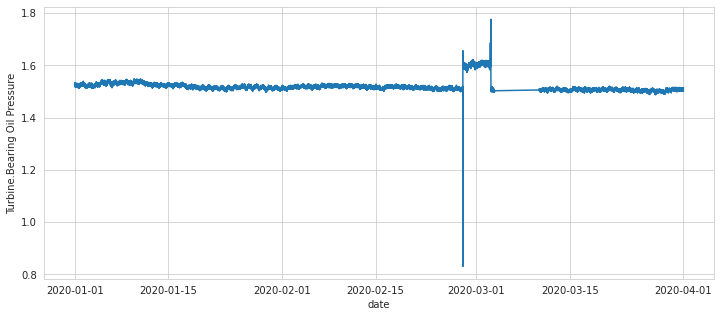

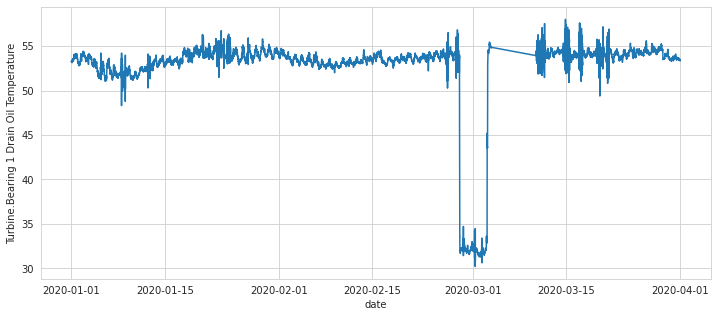

In [40]:
for col in cols:
    plt.figure(figsize=(12,5))
    sns.lineplot(data=data, x="date", y=col)
    plt.show();

# Filter Reference Data

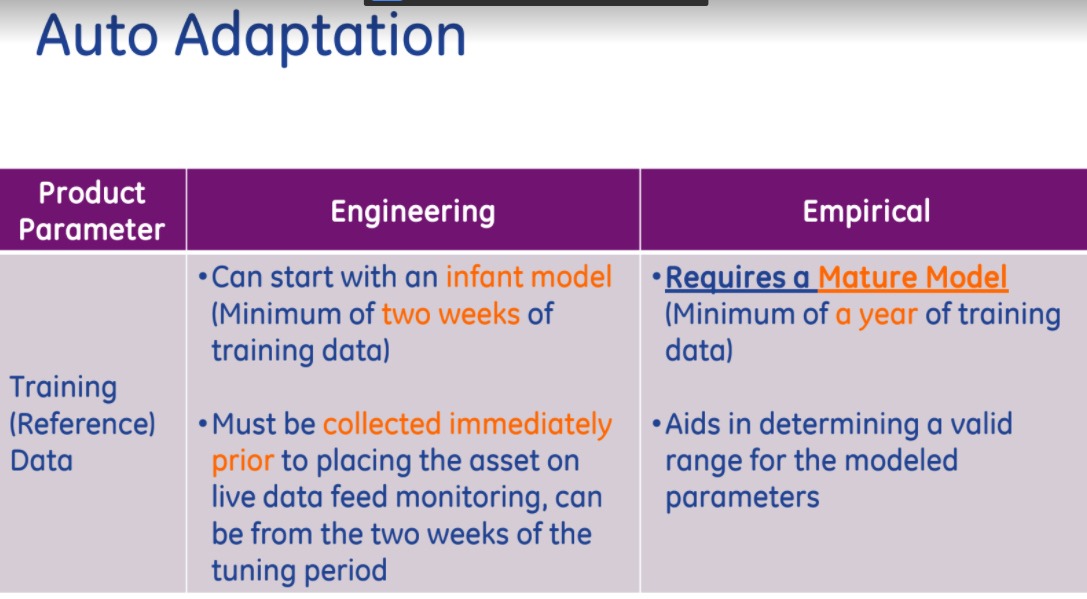

To create an **infant model**, we need at leat two weeks of training data.

## Anomaly model with machine learning

In [41]:
data.head()

,date,Generator Gross Capacity,Turbine Lube Oil Cooler Outlet Temperature,Turbine.Bearing 1 Metal Temperature,Turbine.Bearing Oil Pressure,Turbine.Bearing 1 Drain Oil Temperature
0,2020-01-01 00:00:00,370.734800,43.280968,78.119934,1.525184,53.224167
1,2020-01-01 00:01:00,372.455200,43.316230,78.161460,1.525853,53.224167
2,2020-01-01 00:02:00,373.611400,43.246944,78.178790,1.528792,53.224167
3,2020-01-01 00:03:00,373.408722,43.223320,78.073660,1.527246,53.224167
4,2020-01-01 00:04:00,372.182159,43.314130,78.169060,1.526494,53.224167


 1    120556
-1     10483
Name: anomaly, dtype: int64


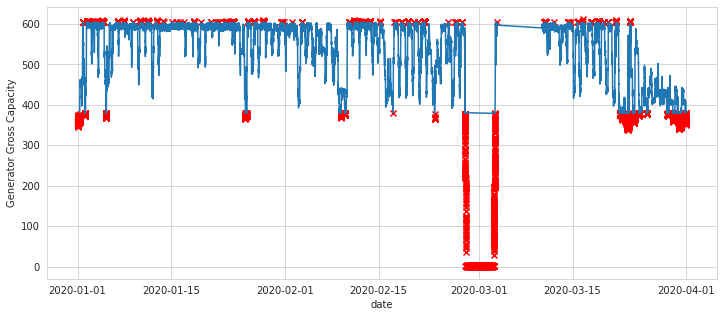

 1    120582
-1     10457
Name: anomaly, dtype: int64


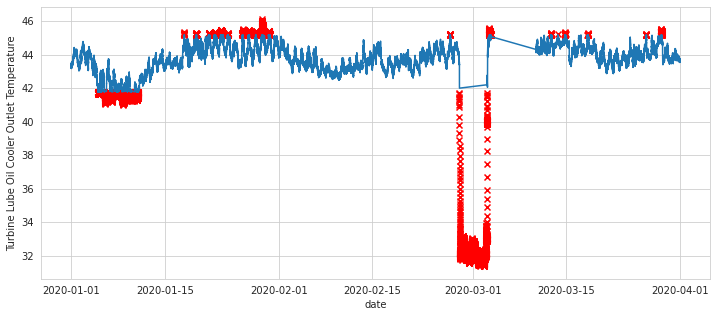

 1    120558
-1     10481
Name: anomaly, dtype: int64


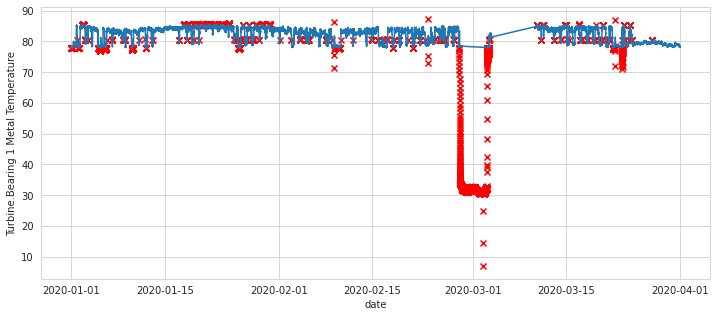

 1    120567
-1     10472
Name: anomaly, dtype: int64


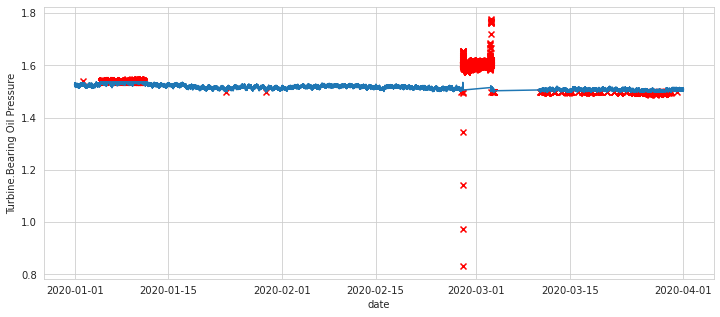

 1    120562
-1     10477
Name: anomaly, dtype: int64


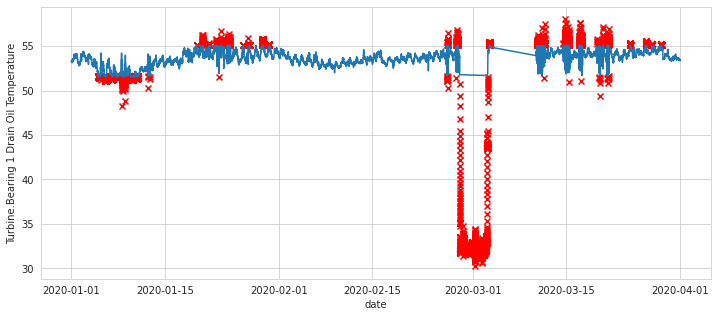

In [43]:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html
from sklearn.ensemble import IsolationForest
# from sklearn.svm import OneClassSVM
# from sklearn.cluster import DBSCAN
# from sklearn.preprocessing import StandardScaler


# for Isolation Forest, the data can not be missing
# thus, we need to interpolate missing values
# data_copy = data.copy()

# for col in cols:
#     data_copy[col] = data_copy[col].interpolate(method='linear')
# select sensor data
X = data[cols]

# scaling
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# univariate method IsolationForest
for col in X.columns:
    # initialize classifier
    clf = IsolationForest(random_state=2021,
                          contamination=0.08)
    
    # fit and predict
    pred = clf.fit_predict(X[col].values.reshape(-1,1))

    # plot
    df = pd.DataFrame(X[col], columns=[col])
    df['date'] = data['date']
    df['anomaly'] = pred 

    print(df['anomaly'].value_counts())

    # plotting
    inliers = df[df['anomaly'] ==  1]
    outliers = df[df['anomaly'] ==  -1]

    plt.figure(figsize=(12,5))
    plt.plot(inliers['date'], inliers[col])
    plt.scatter(x=outliers['date'], y=outliers[col], color='red', marker='x')
    plt.ylabel(col)
    plt.xlabel('date')
    plt.show();
    

# clf = DBSCAN().fit(X_scaled)
# clf = OneClassSVM(gamma="auto")

# predict
# returns -1 for outliers and 1 for inliers.
# pred_class = clf.predict(X_scaled)

# # new data
# data['anomaly'] = pred_class
# data.head()

Note:

- I tried several machine learning models; `IsolationForest`, `OneClassSVM`, and `DBSCAN` to detect anomaly/outlier but the result is still not good enough.
- For example, using `IsolationForest` to detect anomaly/outlier on `Turbine.Bearing Oil Pressure`, the result is still not good to differentiate normal or anomaly, especially on early timestamp.
- I decided to define the `threshold` manually on the next approach for better results. 

## Anomaly model with static value

If we look into GE documentation, there are two types of attributes; `runtime attributes` and `configured attributes`.

In this case, we are categorized in `configured attributes` where we need to define the value by the user (us). We could define the threshold in attribute `Actual (High)` and `Actual (Low)`.

Reference:

https://www.ge.com/digital/documentation/predix-apm/latest/smartsignal-expression-syntax.html

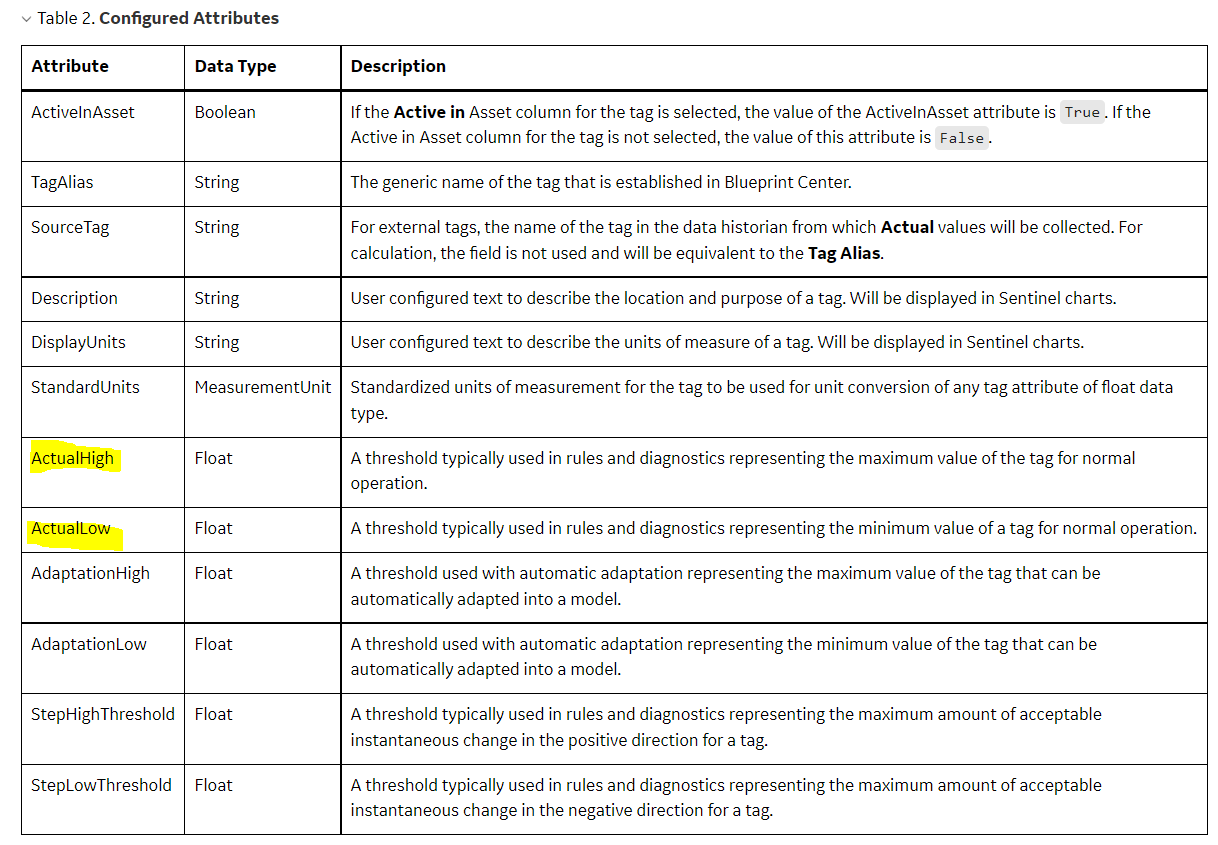

To help set the threshold, we could use `GaussianMixture` from sklearn.

In [44]:
from sklearn.mixture import GaussianMixture

In [45]:
list(data)

['date',
 'Generator Gross Capacity',
 'Turbine Lube Oil Cooler Outlet Temperature',
 'Turbine.Bearing 1 Metal Temperature',
 'Turbine.Bearing Oil Pressure',
 'Turbine.Bearing 1 Drain Oil Temperature']

### Generator Gross Capacity

In [209]:
gross_capacity = data['Generator Gross Capacity'].values.reshape(-1,1)

gm1 = GaussianMixture(n_components=5,
                    #   init_params='random',
                    #   means_init=np.array([[100], [580]]),
                      random_state=2021).fit(gross_capacity)
pred = gm1.predict(gross_capacity)

0    69854
2    28220
3    26022
1     6040
4      903
Name: class, dtype: int64


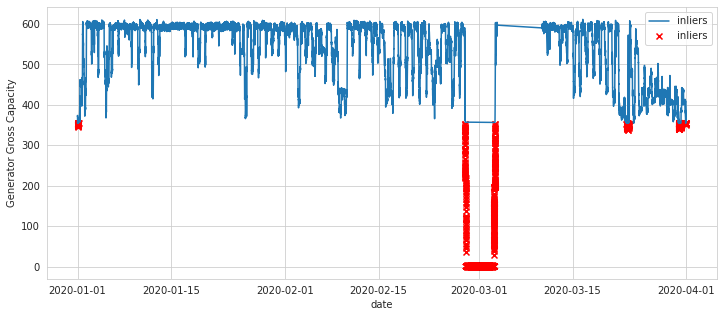

In [210]:
df = pd.DataFrame(np.squeeze(gross_capacity), columns=['Generator Gross Capacity'])
df['date'] = data['date']
df['class'] = pred
print(df['class'].value_counts())

inliers = df[(df['class'] ==  0) | (df['class'] ==  3) | (df['class'] ==  2)] #
outliers = df[(df['class'] ==  1) | (df['class'] ==  4)]

plt.figure(figsize=(12,5))
plt.plot(inliers['date'], inliers['Generator Gross Capacity'])
plt.scatter(x=outliers['date'], y=outliers['Generator Gross Capacity'], color='red', marker='x')
plt.ylabel('Generator Gross Capacity')
plt.xlabel('date')
plt.legend(['inliers','inliers','outliers'])
plt.show();

We use `min` and `max` of inliers as threshold.

In [211]:
# static inliers
inliers.describe()

,Generator Gross Capacity,class
count,124096.000000,124096.000000
mean,544.452517,1.083887
std,70.123398,1.273599
min,354.343500,0.000000
25%,506.855179,0.000000
50%,587.873650,0.000000
75%,593.918260,2.000000
max,611.258600,3.000000


In [212]:
outliers.describe()

,Generator Gross Capacity,class
count,6943.000000,6943.000000
mean,36.916805,1.390177
std,101.250947,1.009178
min,0.190452,1.000000
25%,0.198217,1.000000
50%,0.220328,1.000000
75%,0.220328,1.000000
max,354.282400,4.000000


### Turbine Lube Oil Cooler Outlet Temperature

In [220]:
turb_oil_temp = data['Turbine Lube Oil Cooler Outlet Temperature'].values.reshape(-1,1)

gm2 = GaussianMixture(n_components=4, random_state=2021).fit(turb_oil_temp)
pred = gm2.predict(turb_oil_temp)

3    58829
0    55499
2    10798
1     5913
Name: class, dtype: int64


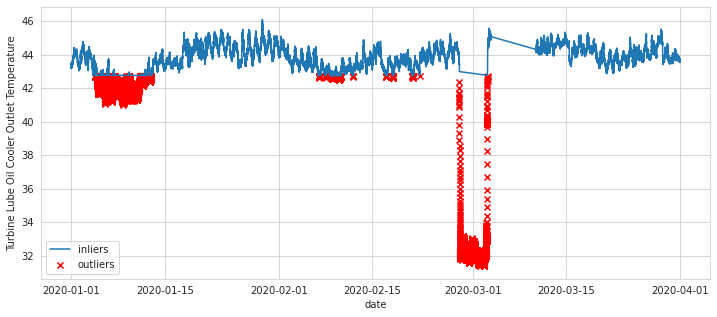

In [221]:
df = pd.DataFrame(np.squeeze(turb_oil_temp), columns=['Turbine Lube Oil Cooler Outlet Temperature'])
df['date'] = data['date']
df['class'] = pred
print(df['class'].value_counts())

inliers = df[(df['class'] ==  0)  | (df['class'] ==  3)]
outliers = df[(df['class'] ==  1) | (df['class'] ==  2)]

plt.figure(figsize=(12,5))
plt.plot(inliers['date'], inliers['Turbine Lube Oil Cooler Outlet Temperature'])
plt.scatter(x=outliers['date'], y=outliers['Turbine Lube Oil Cooler Outlet Temperature'], color='red', marker='x')
plt.ylabel('Turbine Lube Oil Cooler Outlet Temperature')
plt.xlabel('date')
plt.legend(['inliers','outliers'])
plt.show();

In [222]:
# static inliers
inliers.describe()

,Turbine Lube Oil Cooler Outlet Temperature,class
count,114328.000000,114328.00000
mean,44.001110,1.54369
std,0.613909,1.49937
min,42.754530,0.00000
25%,43.528984,0.00000
50%,44.008478,3.00000
75%,44.482371,3.00000
max,46.112560,3.00000


In [223]:
outliers.describe()

,Turbine Lube Oil Cooler Outlet Temperature,class
count,16711.000000,16711.000000
mean,38.539286,1.646161
std,4.774087,0.478174
min,31.354956,1.000000
25%,32.238090,1.000000
50%,41.676200,2.000000
75%,42.216021,2.000000
max,42.754430,2.000000


### Turbine Bearing #01 Metal Temperature

In [99]:
# metal_temp_a = data['Turbine Bearing #01 Metal Temperature'].values.reshape(-1,1)

# gm3 = GaussianMixture(n_components=2, random_state=2021).fit(metal_temp_a)
# pred = gm3.predict(metal_temp_a)

In [100]:
# df = pd.DataFrame(np.squeeze(metal_temp_a), columns=['Turbine Bearing #01 Metal Temperature'])
# df['date'] = data['date']
# df['class'] = pred
# print(df['class'].value_counts())

# inliers = df[df['class'] ==  0]
# outliers = df[df['class'] ==  1]

# plt.figure(figsize=(12,5))
# plt.plot(inliers['date'], inliers['Turbine Bearing #01 Metal Temperature'])
# plt.scatter(x=outliers['date'], y=outliers['Turbine Bearing #01 Metal Temperature'], color='red', marker='x')
# plt.ylabel('Turbine Bearing #01 Metal Temperature')
# plt.xlabel('date')
# plt.legend(['inliers','outliers'])
# plt.show();

In [101]:
# # static inliers
# inliers.describe()

### Turbine.Bearing 1 Metal Temperature

In [230]:
metal_temp_b = data['Turbine.Bearing 1 Metal Temperature'].values.reshape(-1,1)

gm4 = GaussianMixture(n_components=3, random_state=2021).fit(metal_temp_b)
pred = gm4.predict(metal_temp_b)

2    87887
0    37239
1     5913
Name: class, dtype: int64


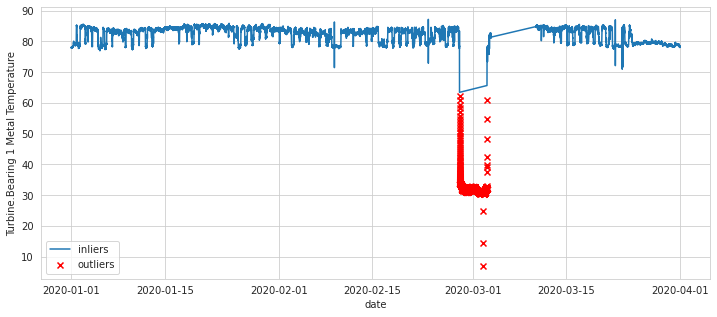

In [231]:
df = pd.DataFrame(np.squeeze(metal_temp_b), columns=['Turbine.Bearing 1 Metal Temperature'])
df['date'] = data['date']
df['class'] = pred
print(df['class'].value_counts())

inliers = df[(df['class'] ==  0) | (df['class'] ==  2)]
outliers = df[(df['class'] ==  1)]

plt.figure(figsize=(12,5))
plt.plot(inliers['date'], inliers['Turbine.Bearing 1 Metal Temperature'])
plt.scatter(x=outliers['date'], y=outliers['Turbine.Bearing 1 Metal Temperature'], color='red', marker='x')
plt.ylabel('Turbine.Bearing 1 Metal Temperature')
plt.xlabel('date')
plt.legend(['inliers','outliers'])
plt.show();

In [232]:
# static inliers
inliers.describe()

,Turbine.Bearing 1 Metal Temperature,class
count,125126.000000,125126.000000
mean,82.324518,1.404776
std,2.300555,0.914420
min,63.441920,0.000000
25%,79.848687,0.000000
50%,83.164272,2.000000
75%,84.181469,2.000000
max,87.180405,2.000000


In [233]:
outliers.describe()

,Turbine.Bearing 1 Metal Temperature,class
count,5913.000000,5913.0
mean,31.866645,1.0
std,1.678770,0.0
min,6.824649,1.0
25%,31.140318,1.0
50%,31.800121,1.0
75%,32.300125,1.0
max,62.227257,1.0


### Turbine.Bearing Oil Pressure

In [240]:
oil_press = data['Turbine.Bearing Oil Pressure'].values.reshape(-1,1)

gm5 = GaussianMixture(n_components=4, random_state=2021).fit(oil_press)
pred = gm5.predict(oil_press)

0    56222
3    53490
2    15289
1     6038
Name: class, dtype: int64


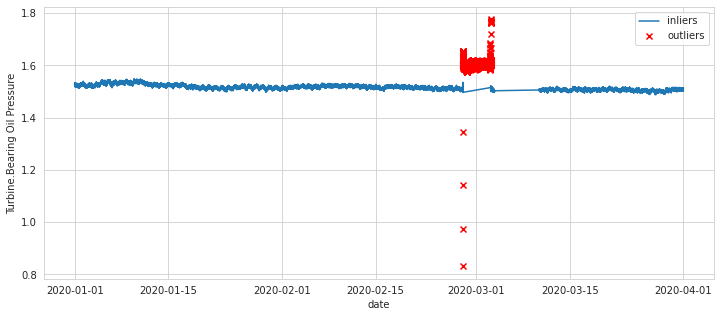

In [241]:
df = pd.DataFrame(np.squeeze(oil_press), columns=['Turbine.Bearing Oil Pressure'])
df['date'] = data['date']
df['class'] = pred
print(df['class'].value_counts())

inliers = df[(df['class'] ==  0) | (df['class'] ==  2) | (df['class'] ==  3)]
outliers = df[(df['class'] ==  1) ]

plt.figure(figsize=(12,5))
plt.plot(inliers['date'], inliers['Turbine.Bearing Oil Pressure'])
plt.scatter(x=outliers['date'], y=outliers['Turbine.Bearing Oil Pressure'], color='red', marker='x')
plt.ylabel('Turbine.Bearing Oil Pressure')
plt.xlabel('date')
plt.legend(['inliers','outliers'])
plt.show();

In [242]:
# static inliers
inliers.describe()

,Turbine.Bearing Oil Pressure,class
count,125001.000000,125001.000000
mean,1.514744,1.528372
std,0.009387,1.415835
min,1.487002,0.000000
25%,1.507097,0.000000
50%,1.513993,2.000000
75%,1.520729,3.000000
max,1.548987,3.000000


In [243]:
outliers.describe()

,Turbine.Bearing Oil Pressure,class
count,6038.000000,6038.0
mean,1.602846,1.0
std,0.018023,0.0
min,0.830781,1.0
25%,1.598191,1.0
50%,1.603708,1.0
75%,1.608023,1.0
max,1.776071,1.0


### Turbine.Bearing 1 Drain Oil Temperature

In [154]:
oil_temp = data['Turbine.Bearing 1 Drain Oil Temperature'].values.reshape(-1,1)

gm6 = GaussianMixture(n_components=4, random_state=2021).fit(oil_temp)
pred = gm6.predict(oil_temp)

0    60349
2    54557
3    10221
1     5912
Name: class, dtype: int64


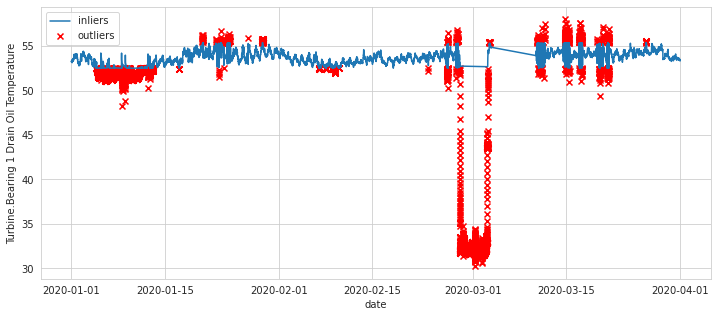

In [155]:
df = pd.DataFrame(np.squeeze(oil_temp), columns=['Turbine.Bearing 1 Drain Oil Temperature'])
df['date'] = data['date']
df['class'] = pred
print(df['class'].value_counts())

inliers = df[(df['class'] ==  0) | (df['class'] ==  2)]
outliers = df[(df['class'] ==  1) | (df['class'] ==  3)]

plt.figure(figsize=(12,5))
plt.plot(inliers['date'], inliers['Turbine.Bearing 1 Drain Oil Temperature'])
plt.scatter(x=outliers['date'], y=outliers['Turbine.Bearing 1 Drain Oil Temperature'], color='red', marker='x')
plt.ylabel('Turbine.Bearing 1 Drain Oil Temperature')
plt.xlabel('date')
plt.legend(['inliers','outliers'])
plt.show();

In [156]:
# static inliers
inliers.describe()

,Turbine.Bearing 1 Drain Oil Temperature,class
count,114906.000000,114906.000000
mean,53.841695,0.949594
std,0.595556,0.998733
min,52.513447,0.000000
25%,53.403114,0.000000
50%,53.870539,0.000000
75%,54.292680,2.000000
max,55.382490,2.000000


## Threshold

Based on the analysis above, we could define a dictionary for `Actual (Low)` and `Actual (High)` for each sensor.

In [322]:
val = [[433., 610.],
       [41., 47.],
    #    [75.298727, 92.167030],
       [80., 87.180405],
       [1.48, 1.54],
       [47., 55.]
    #    [47., 52.]] # customize for fault
threshold = pd.DataFrame(val, columns=['Actual (Low)', 'Actual (High)'], index=list(data)[1:])
threshold

,Actual (Low),Actual (High)
Generator Gross Capacity,433.00,610.000000
Turbine Lube Oil Cooler Outlet Temperature,41.00,47.000000
Turbine.Bearing 1 Metal Temperature,80.00,87.180405
Turbine.Bearing Oil Pressure,1.48,1.540000
Turbine.Bearing 1 Drain Oil Temperature,47.00,55.000000


## Create reference data of an infant model

Let's slice the data in the first `two weeks` as reference data to create an `infant model`.

Since data on `August` has many anomalies, we use data on `September`.

> Note: we need to check if we could make reference data with the `vector size 400`. 

In [323]:
two_weeks = pd.to_datetime('2020-01-01 00:00:00') + pd.DateOffset(days=14)
two_weeks

Timestamp('2020-01-15 00:00:00')

In [324]:
filter = (data['date'] >= '2020-01-01 00:00:00') & (data['date'] < two_weeks)
data_slice = data[filter].reset_index(drop=True)
data_slice.shape

(20160, 6)

In [325]:
print(f"Minimum date: {data_slice['date'].min()}")
print(f"Maximum date: {data_slice['date'].max()}")

Minimum date: 2020-01-01 00:00:00
Maximum date: 2020-01-14 23:59:00


In [326]:
# create state_matrix for an infant model
state_matrix = []
for i in range(len(data_slice)):

    temp = []
    for col in cols:
        actual = data_slice.loc[i,col]
        th_low = threshold.loc[col, 'Actual (Low)']
        th_high = threshold.loc[col, 'Actual (High)']

        if actual > th_low and actual < th_high:
            temp.append(actual)
        else:
            # print(col)
            break

    if len(temp) == 5:
        state_matrix.append(np.array(temp))
    
    if len(state_matrix) == 400:
        state_matrix = np.array(state_matrix).T
        print(i)
        break

2087


In [327]:
# state matrix for an infant model
state_matrix

array([[458.519226  , 460.171722  , 500.1305    , ..., 596.3882    ,
        596.5892    , 595.759949  ],
       [ 43.8634758 ,  43.94      ,  44.2122841 , ...,  44.2428856 ,
         44.1625633 ,  44.0990067 ],
       [ 80.09453   ,  80.04334   ,  80.19663   , ...,  85.17523   ,
         85.07523   ,  85.0070953 ],
       [  1.52714658,   1.5273273 ,   1.524992  , ...,   1.52581728,
          1.5277276 ,   1.52691674],
       [ 53.9026756 ,  53.9026756 ,  53.9457855 , ...,  53.97599   ,
         53.97599   ,  53.97599   ]])

In [328]:
state_matrix.shape

(5, 400)

# Modeling

## VBM

### Create model

In [329]:
def scipy_distance(vector1, vector2, dist='euclidean'):
    if dist == 'euclidean':
        return distance.euclidean(vector1, vector2)
    elif dist == 'braycurtis':
        return distance.braycurtis(vector1, vector2)
    elif dist == 'correlation':
        return distance.correlation(vector1, vector2)
    elif dist == 'canberra':
        return distance.canberra(vector1, vector2)
    elif dist == 'chebyshev':
        return distance.chebyshev(vector1, vector2)
    elif dist == 'cityblock':
        return distance.cityblock(vector1, vector2)
    elif dist == 'minkowski':
        return distance.minkowski(vector1, vector2)
    elif dist == 'sqeuclidean':
        return distance.sqeuclidean(vector1, vector2)
    elif dist == 'cosine':
        return distance.cosine(vector1, vector2)

In [330]:
# function to create a dynamic matrix 
def create_dynamic_matrix(matrix, current_actual):
    
    # get current actual
    # current_actual = matrix[:, -1]

    # calculate similarity
    sim_vec = []
    for i in range(matrix.shape[1]):
        sim = 1 - scipy_distance(current_actual, matrix[:, i], dist='canberra')
        sim_vec.append(sim)
    
    # sort the matrix
    n = 10
    top = np.sort(np.array(sim_vec).argsort()[::-1][:n])
    top_sim_vec = np.array(sim_vec)[top]

    # create dynamic matrix
    dynamic_matrix = matrix[:, top]

    # calculate weight
    weight = np.array([s/np.sum(top_sim_vec) for s in top_sim_vec])

    return dynamic_matrix, weight

def vbm(dynamic_matrix, weight):
    return np.dot(dynamic_matrix, weight.T)

### Prepare data

In [331]:
data.head()

,date,Generator Gross Capacity,Turbine Lube Oil Cooler Outlet Temperature,Turbine.Bearing 1 Metal Temperature,Turbine.Bearing Oil Pressure,Turbine.Bearing 1 Drain Oil Temperature
0,2020-01-01 00:00:00,370.734800,43.280968,78.119934,1.525184,53.224167
1,2020-01-01 00:01:00,372.455200,43.316230,78.161460,1.525853,53.224167
2,2020-01-01 00:02:00,373.611400,43.246944,78.178790,1.528792,53.224167
3,2020-01-01 00:03:00,373.408722,43.223320,78.073660,1.527246,53.224167
4,2020-01-01 00:04:00,372.182159,43.314130,78.169060,1.526494,53.224167


In [332]:
big_matrix = data[cols].values.T
big_matrix.shape

(5, 131039)

### Predict

In [333]:
# OLD CODE TO PREDICT/ESTIMATE

# %%time
# # Estimate t+1 sensor data
# dim_matrix = 400
# x_estimates_vbm = []
# x_actuals = []

# for i in range(big_matrix.shape[1]-dim_matrix):
#     matrix = big_matrix[:, i:i+dim_matrix]
    
#     # create dynamic matrix
#     dm, w = create_dynamic_matrix(matrix)

#     # estimate data at t+1 with input data at t
#     x_est = vbm(dm, w)

#     # get actual to calculate evaluation metric
#     x_actual = big_matrix[:, i+dim_matrix] 

#     x_estimates_vbm.append(x_est)
#     x_actuals.append(x_actual)

# # convert to numpy array
# x_estimates_vbm = np.array(x_estimates_vbm)
# x_actuals = np.array(x_actuals)

In [334]:
%%time
# Estimate t+1 sensor data
dim_matrix = 400
x_estimates_vbm = []
x_actuals = []
state_matrix = state_matrix
th = threshold.values

for i in range(big_matrix.shape[1]):
    # CHECK IF WE NEED TO UPDATE THE STATE MATRIX
    temp = []
    # check for each sensor/tag
    for j in range(big_matrix.shape[0]):
        actual = big_matrix[j,i]
        th_low = th[j][0]
        th_high = th[j][1]

        if actual > th_low and actual < th_high:
            temp.append(actual)
        else:
            break
    # update state_matrix if all of the sensors are normal
    if len(temp) == 5:  # 5 sensors/tags
        temp = np.array(temp).reshape(-1,1)
        # insert new reference vector into
        # state matrix at the bottom or at index-400
        state_matrix = np.insert(state_matrix, [400], temp, axis=1)
        # slice state matrix to make the shape to 400
        # by removing old reference data or at index-0
        state_matrix = state_matrix[:,1:]

    # CREATE DYNAMIC MATRIX
    current_actual = big_matrix[:, i]
    dm, w = create_dynamic_matrix(state_matrix, current_actual)

    # ESTIMATE DATA t+1
    x_est = vbm(dm, w)

    # INSERT INTO LIST
    x_estimates_vbm.append(x_est)

# convert to numpy array
x_estimates_vbm = np.array(x_estimates_vbm)

CPU times: user 32min 1s, sys: 2min 33s, total: 34min 34s
Wall time: 31min 27s


### Evaluate

In [335]:
x_actuals = data[cols].values

In [336]:
# evaluate prognostic
print(f"MSE: {mean_squared_error(x_actuals, x_estimates_vbm)}")
print(f"RMSE: {np.sqrt(mean_squared_error(x_actuals, x_estimates_vbm))}")

MSE: 2906.16732445452
RMSE: 53.90887982934277


Generator Gross Capacity
RMSE: 119.97052208625388


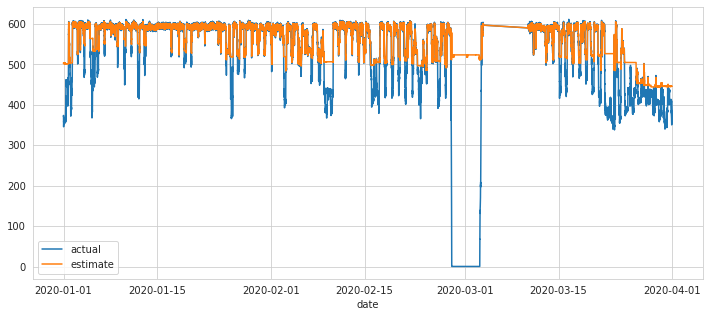

Turbine Lube Oil Cooler Outlet Temperature
RMSE: 2.5630629294686034


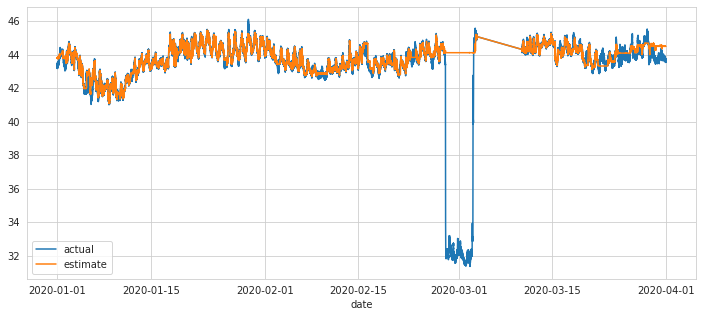

Turbine.Bearing 1 Metal Temperature
RMSE: 10.578620658929236


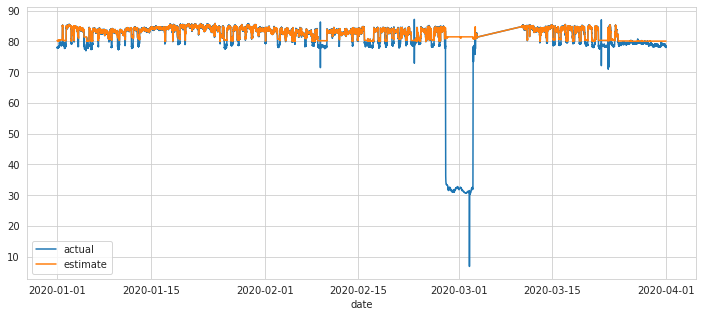

Turbine.Bearing Oil Pressure
RMSE: 0.020085755653233072


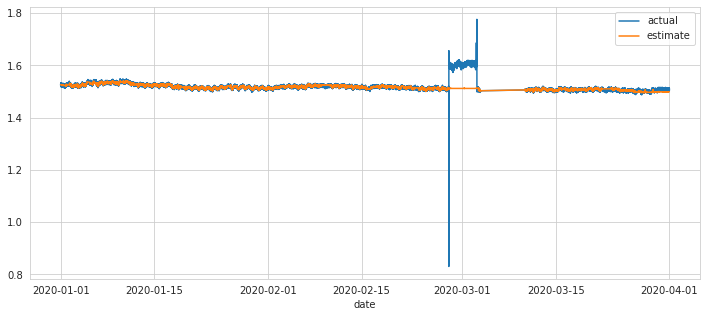

Turbine.Bearing 1 Drain Oil Temperature
RMSE: 4.408349187630045


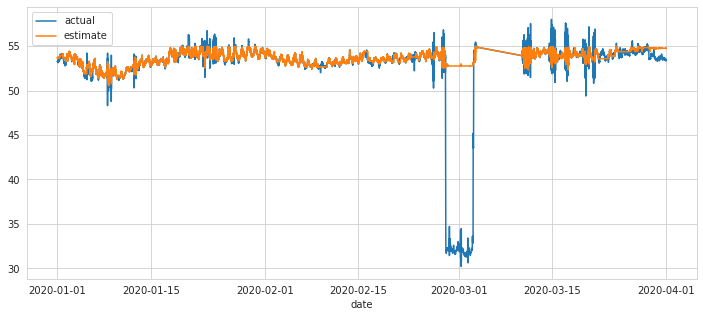

In [337]:
# calculate RMSE for each sensor data
for i,col in enumerate(cols):
    plt.figure(figsize=(12,5))
    print(col)
    print(f"RMSE: {np.sqrt(mean_squared_error(x_actuals[:,i], x_estimates_vbm[:,i]))}")
    sns.lineplot(x=data['date'], y=x_actuals[:,i])
    sns.lineplot(x=data['date'], y=x_estimates_vbm[:,i])
    plt.legend(['actual','estimate'])
    plt.show();

In [338]:
df_state_matrix = pd.DataFrame(state_matrix).T
df_state_matrix.head()

,0,1,2,3,4
0,529.228455,44.039010,82.032135,1.506268,54.635757
1,527.776700,44.027378,81.962190,1.504238,54.635757
2,525.900700,44.236336,81.846780,1.500293,54.635757
3,529.488400,44.163048,81.757225,1.505400,54.634663
4,526.970947,44.162563,81.768630,1.499714,54.633396


In [339]:
df_state_matrix.describe()

,0,1,2,3,4
count,400.000000,400.000000,400.000000,400.000000,400.000000
mean,497.486613,44.234930,80.861107,1.501773,54.595095
std,31.119933,0.173206,0.901289,0.003219,0.142831
min,433.499600,43.913906,80.000305,1.492684,54.335465
25%,472.621773,44.099715,80.096535,1.499389,54.511280
50%,484.725052,44.191140,80.208990,1.501774,54.558880
75%,530.943025,44.363817,81.921309,1.504380,54.678204
max,539.603800,44.984280,82.292080,1.508760,54.994530
